In [1]:
!pip install transformers
import collections
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
puncs = string.punctuation.replace('*', '').replace('#', '')
table = str.maketrans('', '', puncs)
import re
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

import torch
import torch.nn as nn

     |████████████████████████████████| 1.3MB 5.2MB/s 
     |████████████████████████████████| 1.1MB 31.5MB/s 
     |████████████████████████████████| 890kB 46.3MB/s 
     |████████████████████████████████| 2.9MB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=93701c151e1b9ebf5351d98d3aac1034f5f62dc63c5b1998f342e1fe81b40d88
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from transformers import XLNetTokenizer, XLNetModel, XLNetConfig
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# gpt2_config = GPT2Config(vocab_size=tokenizer.vocab_size)
xlnet_model = XLNetModel.from_pretrained('xlnet-base-cased')
# gpt2_model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.6/dist-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


In [3]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token)
print(xlnet_model.config.vocab_size)


32000
<pad>
32000


In [4]:
def checks(w):
    if w in stop_words: return False
    if re.search('[a-zA-Z]', w) and '*' in w: return True
    if not w.isalpha(): return False
    if len(w) == 1 and w not in ['a', 'i', 'o', 'u']: return False
    return True

In [5]:
def getWordCounts(texts, scores, word_tokens):
  l = len(texts)
  wordCounts = {}
  for i in range(l):
    if i % 10000 == 0: print(i)
    text, score = texts[i], scores[i]
    wtoks = word_tokens[i]
    for w in wtoks:
      w = w.strip()
      if w[0] == '_': w = w[1:]
      w = w.lower()
      w = w.translate(table)
      if not checks(w): continue
      wordCounts[w] = wordCounts.get(w, 0) + 1
  return wordCounts

In [6]:
def getWordSentences(texts, word_tokens):
    l = len(texts)
    wordSentences = collections.defaultdict(list)
    for i in range(l):
        if i % 10000 == 0: print(i)
        text = texts[i]
        text = text.lower()
        wtoks = word_tokens[i]
        for w in wtoks:
            w = w.strip()
            if w[0] == '_': w = w[1:]
            w = w.lower()
            w = w.translate(table)
            # w = porter.stem(w)
            if not checks(w): continue
            wordSentences[w].append(text)
    return wordSentences

In [7]:
def getSortedWordScores(wordCounts, asc=False):
    rows_list = []
    for i,w in enumerate(wordCounts):
        dic = {'Word': w, 'Count': wordCounts[w]}
        rows_list.append(dic)
        
    wordScores = pd.DataFrame(rows_list, columns=['Word', 'Count'])
    
    return wordScores

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DetoxBert/'

Mounted at /content/drive


In [9]:
rows = []
with open(path+'toxic.tsv', 'r') as f:
  lines = f.readlines()
  columns = lines[0].split('\t')
  num_cols = len(columns)
  lines = lines[1:]
  for line in lines:
    fields = line.split('\t')
    if len(fields) > num_cols:
      fields = [' '.join(fields[:-num_cols])] + fields[-num_cols:]
    elif len(fields) < num_cols:      
      for i in range(num_cols - len(fields)):
        fields.append('0')
    rows.append(fields)

df = pd.DataFrame(np.array(rows), columns=columns)


In [10]:

# df = pd.read_csv(path+'toxic_fixed.tsv', sep='\t', encoding='utf-8')
print('done: read file')
# only check toxicity values, todo: check others as well

# df = df[['Text', 'Tox']]
df = df[['Text', 'Sev_Tox']]

df.columns = ['Text', 'Score']
df.Score = df.Score.astype(float)
df = df.fillna(0)
toxic_df = df[df['Score'] >= 0.5]
nontox_df = df[df['Score'] < 0.5]
print('done: got toxic data >=0.5')

done: read file
done: got toxic data >=0.5


In [11]:
toxic_df[:3]['Text'].to_numpy()

array(['That violence is both promoted by the government—one parliamentarian has said if he had a lesbian daughter, he would hang her—and carried out by private citizens with government complicity.',
       'In the latest incident, a car bomb exploded at a petrol station in the government-held Damascus suburb of Barzeh, killing 11 people, including civilians, and injuring 40 more, according to both government and opposition reports.',
       'Sebastopol’s local newspaper reports that seven of the 26 people murdered in Sonoma County since 2013 died during marijuana deals.'],
      dtype=object)

In [83]:
# df = pd.read_csv(path+'toxic.tsv', sep='\t+', encoding='utf-8')

pd.set_option('display.max_colwidth', None)
te = toxic_df[toxic_df['Text'].str.contains('If I fought Rafael dos Anjos')]['Text']
te2 = df[df['Text'].str.contains('anonymity may make some youtube')]['Text']

print(te)
te2

56112    "If I fought Rafael dos Anjos, if he didn't pussy out of that last one and showed up, the shots I cracked Nate with in the first eight minutes of that [fight] would've KO'd Rafael dos Anjos stiff.
Name: Text, dtype: object


Series([], Name: Text, dtype: object)

In [13]:
texts = df['Text'].to_numpy()
text = texts[0]
print(tokenizer.tokenize(text))
print(tokenizer.encode(text))


['▁', 'Corruption', '▁involving', '▁the', '▁contractors', '▁is', '▁the', '▁chief', '▁culprit', '▁for', '▁the', '▁prison', '’', 's', '▁problems', ',', '▁according', '▁to', '▁a', '▁recent', '▁report', '▁from', '▁the', '▁Special', '▁Inspector', '▁General', '▁for', '▁Afghanistan', '▁Reconstruction', '—', 'a', '▁congressional', 'ly', '-', 'man', 'dated', '▁watchdog', '▁agency', '.']
[17, 30589, 3458, 18, 9983, 27, 18, 735, 22555, 28, 18, 1840, 165, 23, 708, 19, 549, 22, 24, 644, 419, 40, 18, 3257, 16328, 1016, 28, 1805, 27495, 1559, 101, 5952, 111, 13, 249, 17824, 14003, 1100, 9, 4, 3]


In [14]:
texts = df['Text'].to_numpy()
scores = df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcAll = getWordCounts(texts, scores, word_tokens)
wsentAll = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [15]:
# t = "An impatient commuter probably regretted telling a man to 'f**k himself' on a busy train."
# print(t)
# print(encoded_texts[0])
print(tokenizer.encode(word_tokens[0]))
print(len(wsentAll['pussy']))

[17, 30589, 3458, 18, 9983, 27, 18, 735, 22555, 28, 18, 1840, 165, 23, 708, 19, 549, 22, 24, 644, 419, 40, 18, 3257, 16328, 1016, 28, 1805, 27495, 1559, 101, 5952, 111, 13, 249, 17824, 14003, 1100, 9, 4, 3]
0


In [16]:
texts = toxic_df['Text'].to_numpy()
scores = toxic_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcTox = getWordCounts(texts, scores, word_tokens)
wsentTox = getWordSentences(texts, word_tokens)

0
10000
20000
30000
0
10000
20000
30000


In [17]:
texts = nontox_df['Text'].to_numpy()
scores = nontox_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcNT = getWordCounts(texts, scores, word_tokens)
wsentNT = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000


In [18]:
print(len(wcAll))
print(len(wcTox))
print(len(wcNT))

5472
4911
5358


In [19]:
wordScoresAll = getSortedWordScores(wcAll)

In [20]:
wordScoresTox = getSortedWordScores(wcTox)

In [21]:
wordScoresNT = getSortedWordScores(wcNT, asc=True)

In [22]:
print('All\n', wordScoresAll.head())
print('Toxic\n', wordScoresTox.head())
print('NonToxic\n', wordScoresNT.head())

All
          Word  Count
0  corruption     20
1          ly   3901
2         man   1154
3       dated     21
4          ka    282
Toxic
        Word  Count
0       one    169
1     arian     15
2      held      6
3        ze     79
4  injuring     25
NonToxic
          Word  Count
0  corruption     18
1          ly   2315
2         man    693
3       dated     17
4          ka    171


In [23]:
sAll, sTox, sNT = wordScoresAll, wordScoresTox, wordScoresNT

In [24]:
sAll[sAll['Word'] == 'like'], sTox[sTox['Word'] == 'like'], sNT[sNT['Word'] == 'like']

(    Word  Count
 15  like    275,      Word  Count
 186  like    108,     Word  Count
 15  like    167)

In [25]:
from functools import reduce

dfs = [sAll, sTox, sNT]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='Word'), dfs)

In [26]:
df_merged.columns = ['Word', 'Count_All', 'Count_Tox', 'Count_NT']
df_merged.head()

,Word,Count_All,Count_Tox,Count_NT
0,corruption,20,2,18
1,ly,3901,1586,2315
2,man,1154,461,693
3,dated,21,4,17
4,ka,282,111,171


In [27]:
df_merged['Tox_percent'] = df_merged.apply (lambda row: row['Count_Tox']/(row['Count_All']), axis=1)

In [28]:
df_merged[df_merged['Word'] == 'fuck']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
1194,fuck,955,929,26,0.972775


In [29]:
MINFREQ = 3
df_merged_minfreq = df_merged[(df_merged['Count_All'] > MINFREQ)]

In [30]:
# highTox = df_merged_minfreq.sort_values(["Count_All", "Tox_percent"], ascending = [False, False])

In [31]:
# highTox = df_merged_minfreq.sort_values(["Count_NT", "Count_Tox"], ascending = [True, False])
highTox = df_merged_minfreq.sort_values("Tox_percent", ascending = False)
len(highTox)

4564

In [32]:
highTox[:20]

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
1194,fuck,955,929,26,0.972775
1501,ussy,316,306,10,0.968354
4180,dick,430,414,16,0.962791
3055,hole,667,604,63,0.905547
4747,aca,10,9,1,0.900000
2582,ndi,10,9,1,0.900000
4623,bourg,9,8,1,0.888889
4677,cutter,9,8,1,0.888889
4499,ssian,9,8,1,0.888889
2556,nig,145,128,17,0.882759


In [33]:
# highTox[:20]

In [34]:
ht = highTox[:]

In [35]:
ht[ht['Word'] == 'damn']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
4551,damn,110,66,44,0.6


In [36]:
toxword = ht['Word'][:1]
toxsents = wsentTox['pussy'][:20]
for i, s in enumerate(toxsents):
  if '\t' in s:
    print(i)
    print(s)
    print()

In [37]:
# todo: Compute PMI

In [38]:
xlnet_model.word_embedding

Embedding(32000, 768)

In [39]:
xlnet_model.layer[0]

XLNetLayer(
  (rel_attn): XLNetRelativeAttention(
    (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ff): XLNetFeedForward(
    (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (layer_1): Linear(in_features=768, out_features=3072, bias=True)
    (layer_2): Linear(in_features=3072, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [40]:
import sklearn as sl
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plotVariance(y, title=""):
  x = range(len(y))
  plt.plot(x, y)
  plt.title(title)
  plt.show()
  plt.savefig(title)


# Computes PCs of difference vector
def getPrincipalComponents(D, num_comp=None):
  pca = PCA(n_components=num_comp, svd_solver="auto")
  X = D[0].cpu().detach().numpy()
  pca.fit(X)
  exp_var = pca.explained_variance_ratio_
  return torch.Tensor(np.array(pca.components_)), exp_var

In [87]:
def projection(a, b):
  inner = torch.mm(a, b.T)
  res = a - torch.mm(inner, b)
  return res

**Debiasing GPT2**

In [88]:
num_words = 15
num_sents = 100
tokenizer.pad_token
xlnet_model.config.vocab_size

32000

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LayerXLNet(nn.Module):

    def __init__(self):
        super(LayerXLNet, self).__init__()
        self.xln = xln = xlnet_model
        self.emb = xln.word_embedding
        self.blocks = xln.layer
        self.dtype = xln.dtype

    def forward(self, layer_num, hidden_h, hidden_g, attention_mask):
        # the original code for XLNet uses shapes [len, bsz] with the batch dimension at the end
        # so we move here the first dimension (batch) to the end
        hidden_h = hidden_h.transpose(0, 1).contiguous()
        if hidden_g:
          hidden_g = hidden_g.transpose(0, 1).contiguous()
        qlen, bsz = hidden_h.shape[0], hidden_h.shape[1]

        if layer_num == 0:
            inp = hidden_h
            emb = self.emb(inp)
            emb = emb.permute(1, 0, 2).contiguous()
            return emb, None

        else:

            attention_mask = attention_mask.transpose(0, 1).contiguous() if attention_mask is not None else None

            klen = qlen

            dtype_float = self.dtype

            # data mask: input mask & perm mask
            input_mask = 1.0 - attention_mask
            data_mask = input_mask[None]

            attn_mask = data_mask[:, :, :, None]
            attn_mask = (attn_mask > 0).to(dtype_float)
            non_tgt_mask = -torch.eye(qlen).to(attn_mask)
            non_tgt_mask = ((attn_mask + non_tgt_mask[:, :, None, None]) > 0).to(attn_mask)

            # Positional encoding
            pos_emb = self.xln.relative_positional_encoding(qlen, klen, bsz=bsz)
            pos_emb = self.xln.dropout(pos_emb)

            block = self.blocks[layer_num-1]

            outputs = block(
                hidden_h,
                hidden_g,
                attn_mask_h=non_tgt_mask,
                attn_mask_g=attn_mask,
                r=pos_emb,
                seg_mat=None
            )
            output_h, output_g = outputs[:2]

            # Prepare outputs, we transpose back here to shape [bsz, len, hidden_dim] (cf. beginning of forward() method)
            output_h = output_h.permute(1, 0, 2).contiguous()
            if output_g:
              output_g = output_g.permute(1, 0, 2).contiguous()

            # output = output_g if output_g is not None else output_h
            return output_h, output_g


layerXlnet = LayerXLNet()
layerXlnet = layerXlnet.cuda()


In [90]:
# this algorithm takes in toxic sentence and corresponsing nontoxic sentence
# and returns layer wise PC set {P_0, ..., P_12}
def run_xlnet_algorithm(S_t, S_nt, model, debias=True):
    # inputs are encoded sentences
    W_t, W_nt = S_t, S_nt

    inp_ids_t, attn_masks_t = W_t['input_ids'], W_t['attention_mask']
    inp_ids_nt, attn_masks_nt = W_nt['input_ids'], W_nt['attention_mask']

    u, v, D, PCs, ev = [None] * 13, [None] * 13, [None] * 13, [None] * 13, [None] * 13
    u_out_h, u_out_g = [None]*13, [None]*13
    v_out_h, v_out_g = [None]*13, [None]*13
    
    inp_t = inp_ids_t.cuda()
    atn_t = attn_masks_t.cuda()
    # inp_t = inp_ids_t
    # atn_t = attn_masks_t
    
    # print('inp_t', inp_t.shape, 'atn_t', atn_t.shape)
    u_out_h[0], u_out_g[0] = model(0, inp_t, None, atn_t)
    u[0] = u_out_g[0] if u_out_g[0] is not None else u_out_h[0]

    # print('u_out_g[0]', u_out_g[0].shape)
    # print('u_out_h[0]', u_out_h[0].shape)

    inp_nt = inp_ids_nt.cuda()
    atn_nt = attn_masks_nt.cuda()
    # inp_nt = inp_ids_nt
    # atn_nt = attn_masks_nt
    
    v_out_h[0], v_out_g[0] = model(0, inp_nt, None, atn_nt)
    v[0] = v_out_g[0] if v_out_g[0] is not None else v_out_h[0]
    
    D[0] = u[0] - v[0]  # todo: check dim, torch. ?
    # print('D[0]', D[0].shape)
    PCs[0], ev[0] = getPrincipalComponents(D[0])
    
    PCs[0] = PCs[0].cuda()
    # print('PC[0]', PCs[0].shape, 'ev[0]', ev[0].shape)

    for j in range(1, 13):
        # print("BERT Layer j =", j)
        if debias:
          u_out_h[j-1] = projection(u_out_h[j - 1][0], PCs[j - 1]).unsqueeze(dim=0).cuda()
          v_out_h[j-1] = projection(v_out_h[j - 1][0], PCs[j - 1]).unsqueeze(dim=0).cuda()
          # u_out_g[j-1] = projection(u_out_g[j - 1][0], PCs[j - 1]).unsqueeze(dim=0).cuda()
          # v_out_g[j-1] = projection(v_out_g[j - 1][0], PCs[j - 1]).unsqueeze(dim=0).cuda()
          
        u_out_h[j], u_out_g[j] = model(j, u_out_h[j-1], u_out_g[j-1], atn_t)
        u[j] = u_out_g[j] if u_out_g[j] is not None else u_out_h[j]

        v_out_h[j], v_out_g[j] = model(j, v_out_h[j-1], v_out_g[j-1], atn_nt)
        v[j] = v_out_g[j] if v_out_g[j] is not None else v_out_h[j]
        
        D[j] = u[j] - v[j]  # todo: check dim, torch. ?
        PCs[j], ev[j] = getPrincipalComponents(D[j])
        PCs[j] = PCs[j].cuda()

        # print('PCs[j]', PCs[j].shape)

    return PCs, ev


In [91]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == '_' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      # print(tokens)
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_xlnet_algorithm(encoded_T, encoded_NT, layerXlnet, debias=True)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word fuck num_sent 100
0
PROBLEM!
“removing anonymity may make some youtube commentors (often held up as one of the most trustworthy examples of the internet fuckwad theory at work) think twice about spewing bilious nonsense all over youtube videos,” youtuber jim younkin wrote.
PROBLEM!
v6: ride the lightning at pawtuckaway, 21 votes, fuck the method at pawtuckaway, 5 votes
PROBLEM!
i wasn’t a fan of the south park movie (139 fucks), i thought jay and silent bob was pretty middle of the road (248 fucks)…it just isn’t a major selling point for me.
PROBLEM!
i wasn’t a fan of the south park movie (139 fucks), i thought jay and silent bob was pretty middle of the road (248 fucks)…it just isn’t a major selling point for me.
PROBLEM!
on their collaborative new album who the fuck is chris spencer??, underground chicago rappers vic spencer and chris crack appear wholly ignorant of all recent trends, as if they've emerged untouched from a late-'90s time capsule.
PROBLEM!
the latest to capture t

First PCs [100.0, 13.6851, 4.9145465, 3.3007185, 4.407901, 8.538939, 3.2882466, 8.104864, 8.077431, 11.225111, 26.054054, 45.78858, 60.615498]


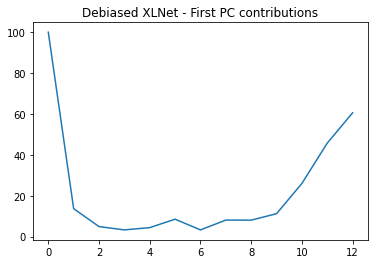

Second PCs [3.8494942e-13, 3.8045845, 2.6910374, 1.898405, 2.6809204, 4.694309, 2.1553912, 4.0532956, 2.5520136, 3.2662983, 3.6650686, 3.8357391, 2.6611526]


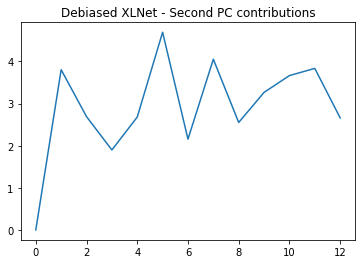

Third PCs [3.5527137e-13, 1.2484424, 2.1247184, 1.659945, 2.1662836, 3.1667411, 1.8365303, 2.4700315, 1.9003289, 2.2703848, 2.1750402, 1.894578, 1.7393897]


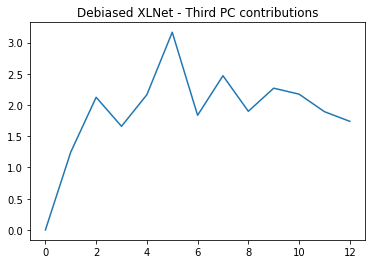

<Figure size 432x288 with 0 Axes>

In [92]:
ev = [e/count*100 for e in ev]
ev1 = ev

first_pcs = [f[0] for f in ev1]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Debiased XLNet - First PC contributions')

second_pcs = [f[1] for f in ev1]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Debiased XLNet - Second PC contributions')

third_pcs = [f[2] for f in ev1]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Debiased XLNet - Third PC contributions')

**Normal XLNet**

In [93]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == '_' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      # print(tokens)
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_xlnet_algorithm(encoded_T, encoded_NT, layerXlnet, debias=False)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word fuck num_sent 100
0
PROBLEM!
“removing anonymity may make some youtube commentors (often held up as one of the most trustworthy examples of the internet fuckwad theory at work) think twice about spewing bilious nonsense all over youtube videos,” youtuber jim younkin wrote.
PROBLEM!
v6: ride the lightning at pawtuckaway, 21 votes, fuck the method at pawtuckaway, 5 votes
PROBLEM!
i wasn’t a fan of the south park movie (139 fucks), i thought jay and silent bob was pretty middle of the road (248 fucks)…it just isn’t a major selling point for me.
PROBLEM!
i wasn’t a fan of the south park movie (139 fucks), i thought jay and silent bob was pretty middle of the road (248 fucks)…it just isn’t a major selling point for me.
PROBLEM!
on their collaborative new album who the fuck is chris spencer??, underground chicago rappers vic spencer and chris crack appear wholly ignorant of all recent trends, as if they've emerged untouched from a late-'90s time capsule.
PROBLEM!
the latest to capture t

First PCs [100.0, 86.80566, 66.03752, 58.87875, 56.688995, 50.193233, 44.668217, 40.5964, 37.576912, 34.580822, 32.72497, 33.28773, 62.039238]


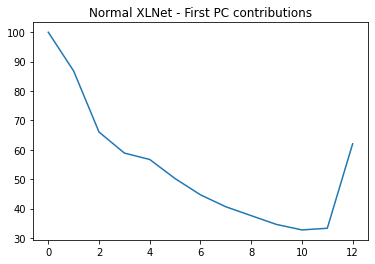

Second PCs [3.8494942e-13, 5.328777, 17.233482, 18.425451, 17.33984, 16.240606, 16.220846, 16.11729, 15.718942, 15.533943, 15.565009, 15.918593, 11.919217]


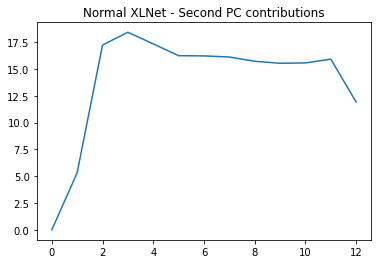

Third PCs [3.5527137e-13, 3.1013432, 7.0144253, 7.546834, 7.862984, 8.598994, 9.140711, 9.657316, 9.9085045, 9.857621, 9.731135, 9.916559, 5.938262]


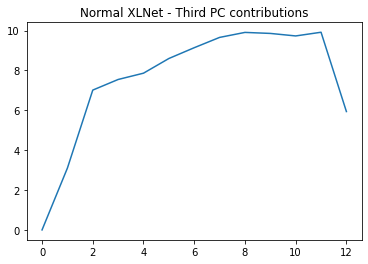

<Figure size 432x288 with 0 Axes>

In [94]:
ev = [e/count*100 for e in ev]
ev4 = ev

first_pcs = [f[0] for f in ev4]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Normal XLNet - First PC contributions')

second_pcs = [f[1] for f in ev4]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Normal XLNet - Second PC contributions')

third_pcs = [f[2] for f in ev4]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Normal XLNet - Third PC contributions')

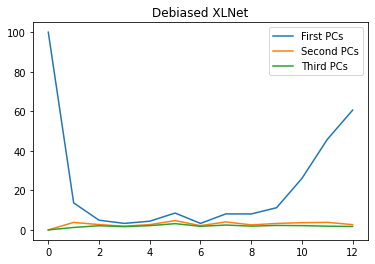

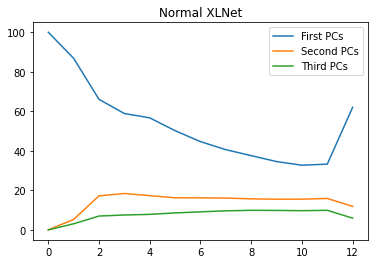

In [95]:
first_pcs = [f[0] for f in ev1]
second_pcs = [f[1] for f in ev1]
third_pcs = [f[2] for f in ev1]

x = range(len(first_pcs))
plt.plot(x, first_pcs)
plt.plot(x, second_pcs)
plt.plot(x, third_pcs)
plt.title("Debiased XLNet")
plt.legend(['First PCs', 'Second PCs', 'Third PCs'])
plt.show()

first_pcs = [f[0] for f in ev4]
second_pcs = [f[1] for f in ev4]
third_pcs = [f[2] for f in ev4]

x = range(len(first_pcs))
plt.plot(x, first_pcs)
plt.plot(x, second_pcs)
plt.plot(x, third_pcs)
plt.title("Normal XLNet")
plt.legend(['First PCs', 'Second PCs', 'Third PCs'])
plt.show()